### Importing the necessary Libraries

In [237]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

### Loading and exploring the data

In [238]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [239]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data preprocessing and splitting

Intially we are converting the data into numpy array for easier manipulation. Then we are splittin the data into validatian and training set

In [240]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)


data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.0

data_train =data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.0

### Neural Network Architecture
This is a 2-layer neural network:


* Input layer: 784 neurons (28x28 pixel images flattened)
* Hidden layer: 10 neurons with ReLU activation
* Output layer: 10 neurons with Softmax activation (one for each digit 0-9)


Initialize weights and biases for the neural network
    
    Returns:
    - W1: Weight matrix for hidden layer (10x784)
    - b1: Bias vector for hidden layer (10x1) 
    - W2: Weight matrix for output layer (10x10)
    - b2: Bias vector for output layer (10x1)
    
   

In [241]:
def init_params():
    W1 = np.random.randn(10,784) * 0.01
    b1 = np.random.randn(10,1) 
    W2 = np.random.randn(10,10) * 0.01
    b2 = np.random.randn(10,1)  
    return W1, b1, W2, b2
    

ReLU (Rectified Linear Unit) activation function
    Returns maximum of 0 and input value
    Used in hidden layer to introduce non-linearity

In [242]:
def ReLU(Z):
    return np.maximum(0, Z)

Softmax activation function for output layer Converts raw scores to probability distribution. Includes numerical stability improvement by subtracting max value

In [243]:
def softmax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

Forward propagation through the network
    
    Args:
    - W1, b1: Hidden layer parameters
    - W2, b2: Output layer parameters  
    - X: Input data (784 x m) where m is number of examples
    
    Returns:
    - Z1: Linear combination before ReLU (hidden layer)
    - A1: Activation after ReLU (hidden layer output)
    - Z2: Linear combination before Softmax (output layer)
    - A2: Final probabilities after Softmax

In [244]:
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2
    

Convert integer labels to one-hot encoded vectors

In [245]:
def one_hot(Y):
    one_hot_Y =np.zeros((Y.size, Y.max()+1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


* Derivative of ReLU function
* Returns 1 for positive values, 0 for negative values
* Used in backpropagation


In [246]:
def deriv_ReLU(Z):
    return Z > 0

### Backpropagation

 Backpropagation - compute gradients for all parameters
    
    Uses chain rule to compute how much each parameter contributed to the error
    
    Args:
    - Z1, A1: Hidden layer values from forward prop
    - Z2, A2: Output layer values from forward prop  
    - W2: Output layer weights
    - X: Input data
    - Y: True labels
    
    Returns gradients for all parameters (dW1, db1, dW2, db2)

In [247]:
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True) 
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2

Update parameters using gradient descent
    
    Args:
    - W1, b1, W2, b2: Current parameters
    - dW1, db1, dW2, db2: Gradients from backpropagation
    - alpha: Learning rate (step size)
    
    Returns updated parameters

In [248]:
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1- alpha * dW1
    b1 = b1- alpha * db1
    W2 = W2- alpha * dW2
    b2 = b2- alpha * db2
    return W1, b1, W2, b2
    

### Prediction and Evaluation

Convert probability distribution to predicted class and Returns index of highest probability (the predicted digit)

In [249]:
def get_predictions(A2):
    return np.argmax(A2,0)

Calculate accuracy by comparing predictions to true labels and Prints both arrays for debugging

In [250]:
def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions ==Y)/ Y.size

### Training Loop

Main training loop - implements gradient descent algorithm
    
    Args:
    - X: Training data (features)
    - Y: Training labels
    - alpha: Learning rate
    - iterations: Number of training epochs
    
    Returns trained parameters

In [251]:
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

### Model Training

In [252]:
print("Training neural network...")
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Training neural network...
Iteration:  0
[7 7 7 ... 7 7 7] [6 6 1 ... 3 8 3]
0.1053170731707317
Iteration:  10
[7 7 7 ... 7 7 7] [6 6 1 ... 3 8 3]
0.1053170731707317
Iteration:  20
[3 3 3 ... 3 3 3] [6 6 1 ... 3 8 3]
0.15360975609756097
Iteration:  30
[8 3 3 ... 3 0 3] [6 6 1 ... 3 8 3]
0.1578780487804878
Iteration:  40
[6 7 7 ... 3 3 3] [6 6 1 ... 3 8 3]
0.19170731707317074
Iteration:  50
[6 7 7 ... 3 4 7] [6 6 1 ... 3 8 3]
0.2284878048780488
Iteration:  60
[9 7 7 ... 3 4 7] [6 6 1 ... 3 8 3]
0.2549512195121951
Iteration:  70
[9 7 7 ... 3 4 7] [6 6 1 ... 3 8 3]
0.3090487804878049
Iteration:  80
[6 7 7 ... 0 4 0] [6 6 1 ... 3 8 3]
0.3820487804878049
Iteration:  90
[6 7 7 ... 0 0 0] [6 6 1 ... 3 8 3]
0.42604878048780487
Iteration:  100
[6 1 1 ... 0 0 0] [6 6 1 ... 3 8 3]
0.4956341463414634
Iteration:  110
[6 1 1 ... 3 0 0] [6 6 1 ... 3 8 3]
0.5736585365853658
Iteration:  120
[6 1 1 ... 3 0 0] [6 6 1 ... 3 8 3]
0.6205365853658537
Iteration:  130
[6 8 1 ... 3 2 0] [6 6 1 ... 3 8 3]
0.6572

### Testing and Visualization

 Make predictions on new data using trained model

In [253]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions



Test prediction on a single example and visualize the digit

In [254]:
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Test on several examples

Prediction:  [6]
Label:  6


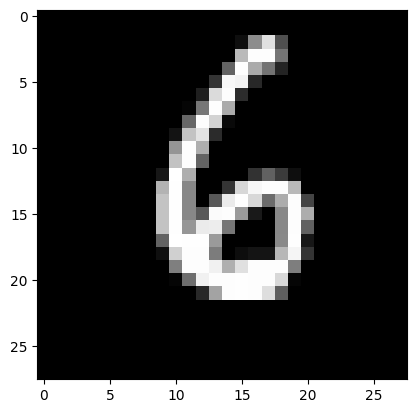

Prediction:  [1]
Label:  6


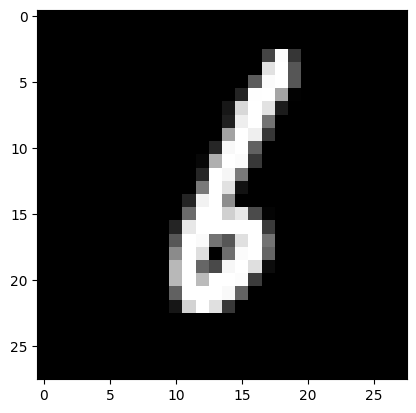

Prediction:  [1]
Label:  1


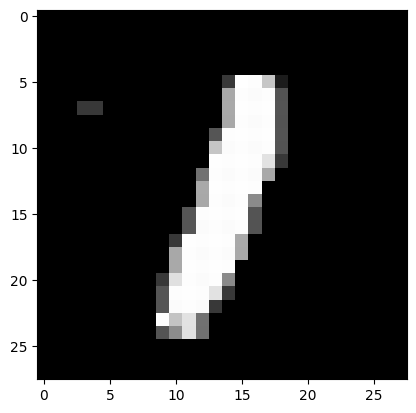

Prediction:  [4]
Label:  4


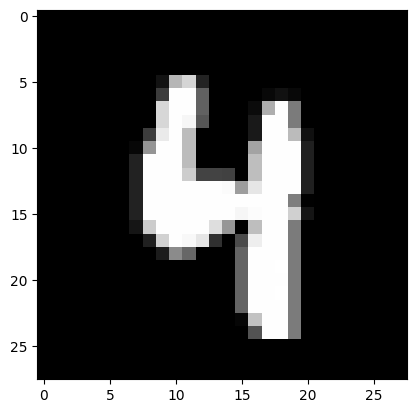

In [255]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

### Final Evaluation

In [256]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[0 3 1 0 7 9 6 1 2 8 8 7 6 7 1 5 0 8 6 3 8 2 3 5 9 2 6 8 6 8 1 7 2 5 9 6 0
 9 8 5 2 4 7 9 2 3 1 2 1 9 2 7 1 3 1 3 9 0 2 0 4 0 1 2 8 0 7 3 7 7 0 1 8 0
 3 7 6 0 4 8 2 0 2 4 2 4 8 9 2 9 3 6 6 6 1 5 6 0 0 5 4 0 6 4 2 9 2 9 5 5 0
 7 5 0 0 0 8 9 6 5 9 5 5 8 9 4 7 7 3 9 5 4 9 0 1 1 0 9 7 9 7 7 5 7 2 5 2 1
 1 2 0 1 1 3 6 0 2 1 4 0 6 1 8 3 9 2 0 9 4 0 3 3 8 4 2 1 5 5 3 7 8 0 7 1 7
 9 7 4 3 8 1 1 4 3 8 3 5 8 0 0 1 0 2 7 9 3 5 1 8 7 5 0 0 8 9 3 6 6 1 2 4 6
 9 4 3 7 6 4 3 6 4 0 4 1 6 1 1 5 2 3 6 7 6 3 7 8 8 7 3 9 3 1 3 9 9 7 1 8 5
 6 0 0 3 7 1 7 1 1 0 0 3 1 7 7 4 4 6 2 1 4 1 6 7 8 9 3 6 2 2 4 0 7 2 7 2 3
 1 6 2 2 1 1 0 6 0 0 1 3 3 1 3 3 7 4 2 5 5 2 3 5 1 9 4 0 1 0 1 4 4 9 2 7 0
 9 0 0 0 7 5 2 1 1 9 6 8 2 6 9 1 4 1 0 6 3 6 2 8 2 5 0 5 0 4 3 4 3 1 2 6 1
 5 8 6 9 8 3 3 1 1 1 6 9 4 9 8 0 6 2 8 7 5 4 6 5 1 3 5 0 5 6 3 8 0 4 1 6 3
 7 1 4 9 7 8 4 9 2 4 0 2 6 7 6 9 5 6 3 5 4 8 2 3 7 2 5 6 4 1 9 6 4 7 9 7 6
 6 1 3 7 3 9 6 6 6 6 2 7 9 7 1 8 1 9 9 7 1 9 1 1 6 0 6 3 2 2 0 1 6 6 1 6 0
 8 2 7 1 3 0 1 8 0 4 6 5 

0.816

**Neural Network Architecture**
This is a simple feedforward neural network with:


* 784 input neurons (28×28 pixels)
* 10 hidden neurons with ReLU activation
* 10 output neurons with Softmax activation


**Training Process**


* Forward Propagation: Data flows through network to generate predictions
* Loss Calculation: Compare predictions with true labels
* Backpropagation: Calculate gradients using chain rule
* Parameter Update: Adjust weights and biases using gradients
* Repeat: Continue for specified number of iterations


**Key Functions**


* ReLU: Introduces non-linearity, allows network to learn complex patterns
* Softmax: Converts raw scores to probability distribution
* One-hot encoding: Represents categorical labels as binary vectors
* Gradient Descent: Optimization algorithm that minimizes prediction error


The model achieves approximately 82% accuracy on the validation set, which is quite good for such a simple architecture!